In [ ]:
'''
L'objectif de ce projet est d'observer s'il existe des 'déserts sportifs', 
lieux en France où les infrastrcutures sportives manquent. 
La question sera alors d'essayer d'expliquer ces déserts sportifs, que ce soit par des raisons économiques ou politiques. 
Enfin, il s'agira de comparer la carte des déserts sportifs avec d'autres cartes connues, à l'instar des déserts médicaux.
'''

In [2]:
''' 
Il convient d'abord d'importer tous les modules python nécessaires au travail
'''
!pip install py7zr geopandas openpyxl tqdm s3fs --quiet
!pip install PyYAML xlrd --quiet
!pip install cartiflette --quiet
!pip install contextily 

import numpy as np
import numpy.linalg as al
import matplotlib.pyplot as plt 
import pandas as pd
import geopandas as gpd
from cartiflette import carti_download
import requests
import zipfile
import io
import contextily as ctx
import tempfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.2 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [contextily]9 [geopy]io]


In [3]:
'''
On importe ensuite nos jeux de données
Le jeu de données principal
'''
url = "https://data.sports.gouv.fr/api/explore/v2.1/catalog/datasets/equipements-sportifs/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
equipement = pd.read_csv(url, sep=";", low_memory=False)

'''
Un jeu de données csv sur des informations économiques et démographiques au niveau des communes
'''

urlpop = "https://www.insee.fr/fr/statistiques/fichier/2521169/base_cc_comparateur_csv.zip"
response = requests.get(urlpop)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open("base_cc_comparateur.csv") as csvfile:
        df_communes = pd.read_csv(csvfile, sep=";", low_memory=False)

'''
Jeu de données politiques au niveau des communes: résultats des législatives 2024 (2nd tour)
'''

url2="https://www.data.gouv.fr/api/1/datasets/r/5a8088fd-8168-402a-9f40-c48daab88cd1"
legislatives2=pd.read_csv(url2, sep=";", low_memory=False)


In [4]:
'''
Il s'agit maintenant de laver nos jeux de données afin de les réunir ensuite à l'aide des codes INSEE.
On conserve seulement les variables qui peuvent nous intéresser.
'''

cols = ["Nom de l'installation sportive", "Code Postal", "Commune nom", "Commune INSEE", "Département Code", "Département Nom", "Densite Catégorie", "Nom de l'équipement sportif", "Type d'équipement sportif", "Longitude", "Latitude"]
equipement = equipement[cols]

cols=["CODGEO", "P22_POP", "NAISD24", "DECESD24", "P22_MEN","MED21", "TP6021", "P22_CHOM1564"]
df_communes = df_communes[cols]

cols=["Code commune", "Libellé commune"]
cols= cols + [(f"% Voix/exprimés {i}") for i in range(1,4)]+[ (f"Nuance candidat {i}") for i in range(1, 4)]
legislatives2= legislatives2[cols]

In [5]:
'''
On renomme maintenant les colonnes afin de pouvoir concatener les dataframes. 
'''

df_communes = df_communes.rename(columns={"CODGEO": "Commune INSEE"})
legislatives2 = legislatives2.rename(columns={"Code commune": "Commune INSEE"})

df_final = (
    equipement
    .merge(df_communes, on="Commune INSEE", how="left")
    .merge(legislatives2, on="Commune INSEE", how="left")
)

In [6]:
'''
On ajoute dans ce dataframe uniquement le parti politique en tête lors des élections de 2024, c'est-à-dire la nuance qui a eu
le plus de % Voix/exprimés. Pour calculer le max il faut donc remplacer les valeurs prises qui ne sont pour l'instant pas dans le bon format.
'''
cols_voix = ["% Voix/exprimés 1", "% Voix/exprimés 2", "% Voix/exprimés 3"]

for c in cols_voix:
    df_final[c] = (df_final[c].astype(str).str.replace("%", "", regex=False).str.replace(",", ".", regex=False).str.strip())

df_final["% Voix/exprimés 3"]=df_final["% Voix/exprimés 3"].str.replace("nan","0")

cols_valeurs = df_final.columns[19:22]
cols_associees = df_final.columns[22:25]

valeurs = df_final[cols_valeurs].to_numpy()
associees = df_final[cols_associees].to_numpy()
idx_max = np.argmax(valeurs, axis=1)
df_final["Score vainqueur"] = valeurs[np.arange(len(df_final)), idx_max]
df_final["Parti vainqueur"] = associees[np.arange(len(df_final)), idx_max]

In [7]:
'''
En faisant le test avec ma commune d'origine, on se rend compte que des lignes sont parfois en double, voire triple, on va donc supprimer ces doublons.
'''

test=df_final[df_final["Commune nom"] == "Eschau"]

df_final = df_final.drop_duplicates()

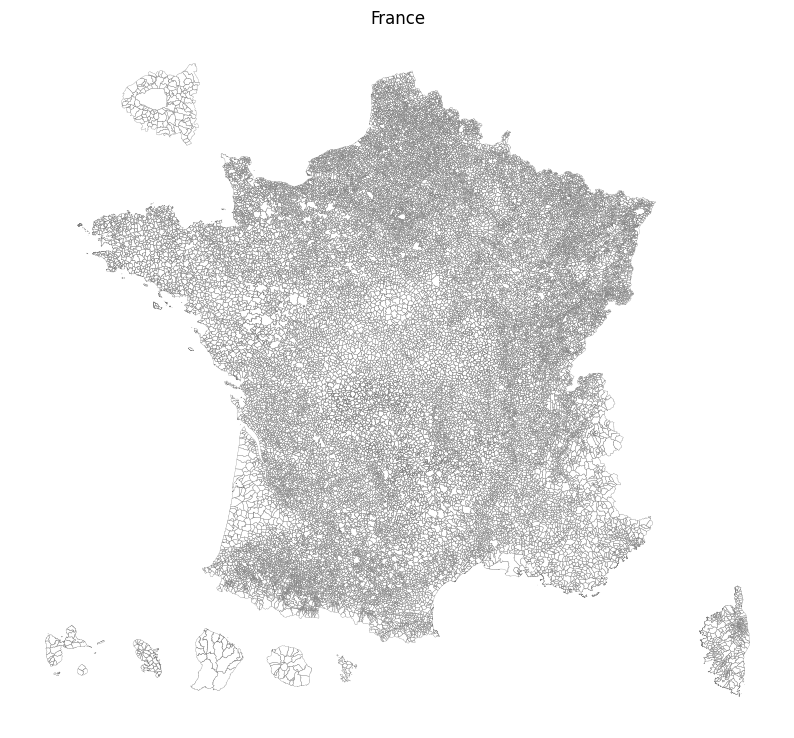

In [11]:
'''
Maintenant faisons une carte de la france avec toutes les infrastructures sportives.
1) On trace la carte de la France
'''
url_or_gdf = carti_download(
    "France",
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

if isinstance(url_or_gdf, gpd.GeoDataFrame):
    gdf = url_or_gdf
else:
    with tempfile.NamedTemporaryFile(suffix=".geojson", delete=False) as tmp:
        tmp.write(requests.get(url_or_gdf).content)
        local_path = tmp.name
    gdf = gpd.read_file(local_path)

gdf = gdf.to_crs("EPSG:2154")
ax = gdf.boundary.plot(figsize=(10, 12), linewidth=0.2, color="gray")
ax.set_title("France")
ax.set_axis_off()
plt.show()


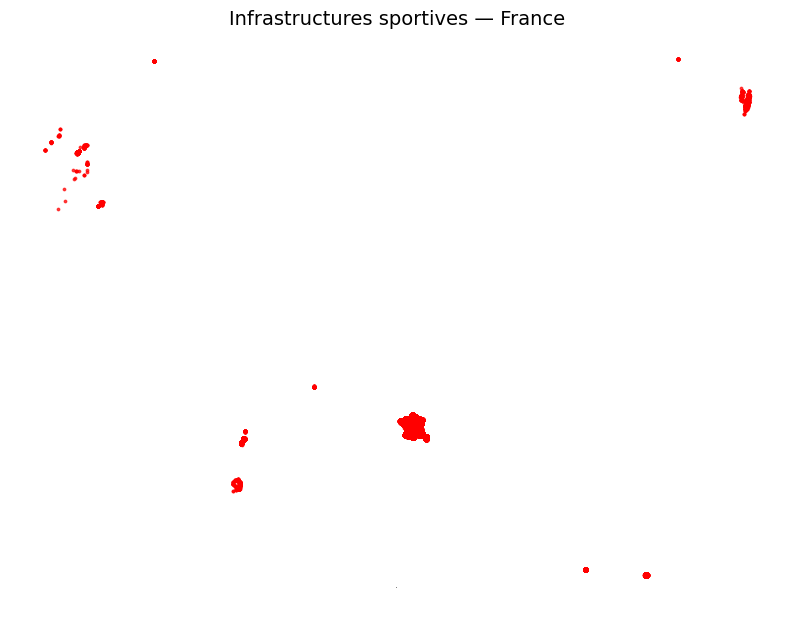

In [14]:
'''
2)On place les points des infrastructures
'''

df_final["Longitude"] = pd.to_numeric(df_final["Longitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df_final["Latitude"]  = pd.to_numeric(df_final["Latitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df_final = df_final.dropna(subset=["Longitude", "Latitude"]).reset_index(drop=True)

gdf_pts = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final["Longitude"], df_final["Latitude"]),
    crs="EPSG:4326"
)

gdf_pts = gdf_pts.to_crs("EPSG:2154")

fig, ax = plt.subplots(figsize=(10, 12))
url_or_gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, color="red")
ax.set_title("Infrastructures sportives — France", fontsize=14)
ax.set_axis_off()
plt.show()


/tmp/ipykernel_1027/2711687836.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_metropole["Longitude"] = pd.to_numeric(df_final_metropole["Longitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
/tmp/ipykernel_1027/2711687836.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_metropole["Latitude"]  = pd.to_numeric(df_final_metropole["Latitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")


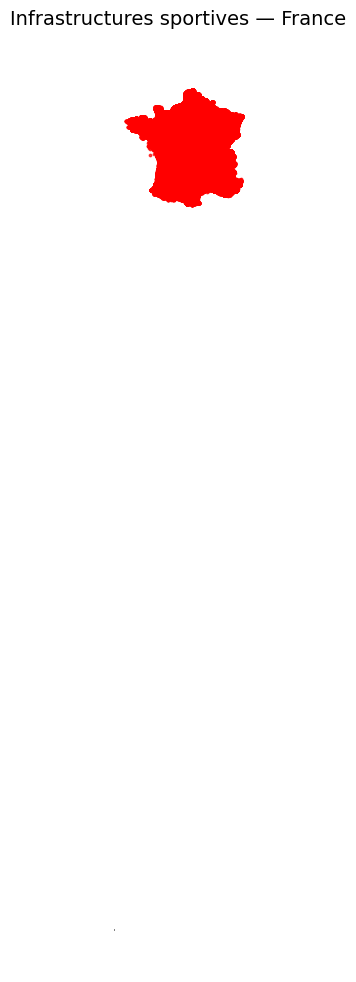

In [17]:
'''
On constate qu'on trace les pointds sur une carte monde, il faut donc enlever les données des DROM de notre df et 
garder uniquement les communes avec un code INSEE entre les départements du 01 et du 95.
'''

df_final["Département Code"] = pd.to_numeric(df_final["Département Code"], errors="coerce")

df_final_metropole = df_final[(df_final["Département Code"] >= 1) & (df_final["Département Code"] <= 95)]

df_final_metropole["Longitude"] = pd.to_numeric(df_final_metropole["Longitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df_final_metropole["Latitude"]  = pd.to_numeric(df_final_metropole["Latitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df_final_metropole = df_final_metropole.dropna(subset=["Longitude", "Latitude"]).reset_index(drop=True)

gdf_pts = gpd.GeoDataFrame(
    df_final_metropole,
    geometry=gpd.points_from_xy(df_final_metropole["Longitude"], df_final_metropole["Latitude"]),
    crs="EPSG:4326"
)

gdf_pts = gdf_pts.to_crs("EPSG:2154")

fig, ax = plt.subplots(figsize=(10, 12))
url_or_gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, color="red")
ax.set_title("Infrastructures sportives — France", fontsize=14)
ax.set_axis_off()
plt.show()